# Práctica Sistemas de Recomendación

**Francisco Javier Tébar Martínez**

29/04/2019

# Ejercicio 2

## Creación del entorno de Spark y carga de datos

Creamos el entorno de configuración de spark.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.2/spark-2.4.2-bin-hadoop2.7.tgz
!tar xf spark-2.4.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.2-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf
sparkSession = SparkSession.builder.master("local[*]").getOrCreate()
sparkContext = sparkSession.sparkContext

In [0]:
import os
import pandas as pd
import numpy as np

Clonamos el repositorio de github donde se han almacenado los datos.

In [5]:
!git clone --recursive https://github.com/fjtm/Sistemas-de-recomendacion.git

Cloning into 'Sistemas-de-recomendacion'...
remote: Enumerating objects: 1610, done.
remote: Counting objects: 100% (1610/1610), done.
remote: Compressing objects: 100% (1506/1506), done.
remote: Total 1610 (delta 4), reused 1606 (delta 2), pack-reused 0
Receiving objects: 100% (1610/1610), 10.85 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (4/4), done.


Cargamos los datos

In [0]:
plays = sparkSession.read.parquet('Sistemas-de-recomendacion/datos/lastfm_mini.parquet')

In [7]:
plays.show(5)

+--------------------+--------------------+-----------+-----+
|             user_id|           artist_id|artist_name|plays|
+--------------------+--------------------+-----------+-----+
|8358173502fcfd30b...|382f1005-e9ab-468...|       2pac| 54.0|
|f434362a46b823536...|382f1005-e9ab-468...|       2pac|545.0|
|135750e1a2107ae20...|382f1005-e9ab-468...|       2pac| 54.0|
|41a072560f38290a2...|382f1005-e9ab-468...|       2pac|201.0|
|57da4f4db6fc10eb7...|382f1005-e9ab-468...|       2pac| 86.0|
+--------------------+--------------------+-----------+-----+
only showing top 5 rows



## Imprimimos por pantalla los 20 artistas que más aparecen

Consideramos que los artistas que más aparecen son aquellos con un mayor número de reproducciones. Así agrupamos por artist_id, sumamos por plays y ordenamos descendentemente.

In [8]:
top_artist = (
  plays
    .groupBy(["artist_id","artist_name"])
    .sum()
    .select(["artist_name","sum(plays)"])
    .orderBy("sum(plays)", ascending = False)
).toPandas()[0:20]

top_artist

,artist_name,sum(plays)
0,the beatles,878602.0
1,radiohead,840236.0
2,pink floyd,492270.0
3,coldplay,489212.0
4,metallica,472438.0
5,muse,449794.0
6,red hot chili peppers,413867.0
7,nine inch nails,402385.0
8,system of a down,394673.0
9,nightwish,384564.0


## Sistema de recomendación por filtro colaborativo ALS (Alternating Least Squares)

Para crear un sistema de recomendación basado en filtros colaborativos utilizaremos la función **ALS** proporcionada por **PYSPARK.ML**. El funcionamiento de este método se basa en la factorización de matrices y se puede resumir en la siguiente imágen: 

<img src="https://raw.githubusercontent.com/fjtm/Sistemas-de-recomendacion/master/img/tumblr_inline_nq15z3n02b1t7c979_540.png" height="350" width="600"/>

Los hiperparámetros principales del modelo **ALS** en **pyspark** son: 

<li> **regParam** : Constante de regularización del modelo.
<li> **rank** : Número de factores latentes a considerar. 
<li> **maxIter** : Número de iteraciones que realizará el algorítmo. 
<li> **numUserBlocks** : Número de bloques de usuarios.
<li> **numItemBlocks** : Número de bloques de items.
  
El modelo también cuenta con tres parámetros que toman como valores las columnas de usuarios, items y ratings. 
  
Por último destacar el parámetro **coldStartStrategy**, el cual evita que el modelo falle al encontrarse con un usuario nuevo. 

En nuestro caso no disponemos de ratings propiamente dichos, sino que tenemos el número de reproducciones de cata artista por cada usuario. De esta manera, es razonable suponer que aquellos músicos con un mayor número de reproducciones tendrán un mayor rating (aunque no tiene porqué ser así). De esta manera utilizaremos el número de reproducciones como escala de ratings. 

En un primer lugar se creo un sistema de recomendación ALS con el número de reproducciones sin modificar. Si se hace así, tenemos el problema de que estos valores están muy esparcidos en orden de magnitud. Y así, nos enfrentamos a dos situaciones:

<li> Dejamos que el modelo realice un gran overfit con valores razonables en los parámetros. Lo cual repercute en que aunque las recomendaciones pueden ser razonables hacemos el modelo tremendamente rígido.
  
<li> Nos vemos obligados a utilizar valores de regParam enormes (superiores a 100), para controlar el overfit haciendo el modelo más flexible, pero con unos resultados nefastos. 
  
Para controlar este problema hay que escalar el número de reproducciones que se encuentra en un rango aproximado de 1-60000. Una manera de hacerlo es aplicando el logaritmo al número de reproducciones, que aunque no es la mejor manera de escalar nos permite preservar el orden. Destacar que podemos aplicar el logaritmo puesto que el menor número de reproducciones es 1. 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import time
from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql import Row

In [0]:
plays_log = plays.withColumn("plays_log", F.log("plays"))

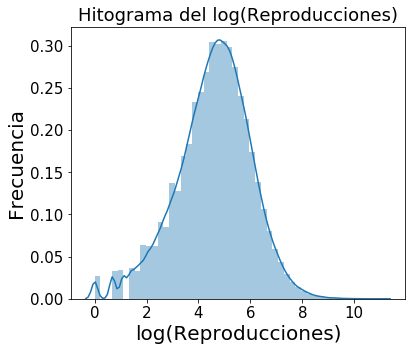

In [11]:
plt.figure(figsize=(6, 5))
g = sns.distplot(plays_log.select("plays_log").collect())
g.set_xlabel("log(Reproducciones)", fontsize=20)
g.set_ylabel("Frecuencia", fontsize=20)
g.tick_params(axis='both', which='major', labelsize=15)
g.set_title("Hitograma del log(Reproducciones)", fontsize=18)
plt.show()

Como podemos ver conseguimos que las reproducciones se encuentren en un rango aproximado de entre 0-10. 

Finalmente hay que tener otra consideración antes de buscar los hiperparámetros del modelo y es que las columnas de usuarios (user_id) e items (artist_id) solamente admiten números enteros. Para solucionarlo utilizamos la función **StringIndexer** disponible nuevamente en **pyspark.ml**. Como su nombre indica lo único que hace es coger una lista e indexarla. Este paso lo iremos implementando como sea conveniente en cada fase del desarrollo del modelo. 

### Obtención de los hiperparámetros

Lo primero de todo es obtener los hiperparámetros del modelo. Aunque en este caso tenemos principalmente los cinco hiperparámetros explicados anteriormente trabajaremos en la búsqueda intensiva de dos de ellos: regParam y rank a los que he llegado a la conclusión que son los más importantes. Se han probado combinaciones del resto de los parámetros dentro de las posibilidades:

<li> Para maxIter debido a la falta de memoría solamente podiamos originalmente realizar 5 iteraciones. Para intentar reducir esta limitación he realizado la práctica en Google Colab lo que me permitió llegar hasta 20 iteraciones. Finalmente decidí elegir 10 iteraciones debido a que con 20 tardaba mucho más y los resultado eran similares a los obtenidos con 10. 
  
<li> Con respecto a numUserBlocks y numItemBlocks he explorado menos estos hiperparámetros debido al enorme coste computacional que requería modificarlos en un rango importante. Los pocos cambios que he probado no han resultado ser muy relevantes en el resultado final. Así, realizaré el cross validate con el valor por defecto y para el modelo final bajaré este valor a 2, que a mi entender es el que mejores recomendaciones devuelve. 

Teniendo en cuenta todo lo anteriormente dicho busquemos los dos hiperparámetros restantes.

Primero utilizamos StringIndexer antes de hacer cross validate para evitar errores de indexado.

In [0]:
indexer_user = StringIndexer(inputCol="user_id", outputCol="user_id_index")
indexer_artist = StringIndexer(inputCol="artist_id", outputCol="artist_id_index")
indexer_pipeline = Pipeline(stages=[indexer_user, indexer_artist])

plays_log_train_indexer = indexer_pipeline.fit(plays_log)
plays_log_indexer = plays_log_train_indexer.transform(plays_log)

A continuación separamos los datos en conjuntos de train y test. Train para buscar los valores y test para testear el overfit. 

In [0]:
(train, test) = plays_log_indexer.randomSplit([0.8, 0.2], seed=12)

Definimos el modelo ALS



In [0]:
ALS_search = ALS(

    maxIter=10,
    userCol="user_id_index", 
    itemCol="artist_id_index", 
    ratingCol="plays_log",
    coldStartStrategy="drop",
    numUserBlocks=10,
    numItemBlocks=10

)

Configuramos la rejilla sobre la que buscar los parámetros

In [0]:
paramGrid = (

    ParamGridBuilder()
    .addGrid(ALS_search.rank, [1, 5, 10, 25, 50, 100])
    .addGrid(ALS_search.regParam, [0.001, 0.01, 0.1, 1, 10])
    .build()

)

Utilizamos RMSE como métrica para evaluar el cross validate. 

In [0]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="plays_log",
    predictionCol="prediction"
)

In [0]:
crossval = CrossValidator(

    estimator=ALS_search,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3 # Hacemos CV con 3-folds

) 

Buscamos los parámetros. Es importante destacar que este proceso lleva bastante tiempo. 

In [18]:
t0 = time.time()
cvModel = crossval.fit(train)
print("Tiempo de búsqueda:", np.round((time.time() - t0)/60,2), "min")

Tiempo de búsqueda: 54.32 min


Tenemos que los mejores hiperparámetros son:

In [19]:
results = [([{key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())], metric) for params, metric in zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics)] 
params = pd.DataFrame([(element[0]['rank'], element[1]['regParam']) for element in pd.DataFrame([(results[i][0],results[i][1]) for i in range(len(results))])[0]])
metric = pd.DataFrame([element for element in pd.DataFrame([(results[i][0],results[i][1]) for i in range(len(results))])[1]])
params.columns = ['rank', 'regParam']
metric.columns = ['metric']
results_df = pd.concat([metric, params], axis = 1)
best_results = results_df.sort_values("metric", ascending = True).head(1)
best_results

,metric,rank,regParam
2,0.779533,1,0.1


Es muy útil ver mediante un mapa como varía la métrica de error elegida en función de los hiperparámetros. 

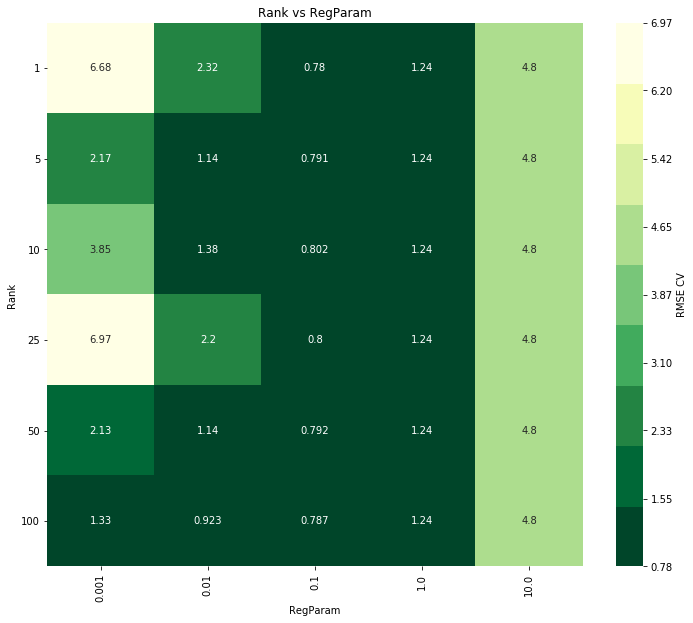

In [20]:
n_colors = 9
cMap = plt.cm.get_cmap("YlGn_r",lut=n_colors) 

plt.figure( figsize=(12, 10))
plt.title('Rank vs RegParam')

m_t_s = results_df.sort_values(by=['rank', 'regParam'])['metric'].values.reshape(len(np.unique(results_df['rank'])), -1)
h_map = sns.heatmap(m_t_s, 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(np.unique(results_df['regParam'])),
                    yticklabels=list(np.unique(results_df['rank'])),
                    cbar_kws={'label': 'RMSE CV'},
                    fmt=".3")
h_map.set_ylabel('Rank')
h_map.set_xlabel('RegParam')

plt.xticks(rotation='vertical')
plt.yticks(rotation=0)

minimo = min(results_df.sort_values(by=['rank', 'regParam'])['metric'])
maximo = max(results_df.sort_values(by=['rank', 'regParam'])['metric'])

cbar = h_map.collections[0].colorbar
l_ticks = [np.round(np.linspace(minimo, maximo, 9),2)][0]
cbar.set_ticks(l_ticks)

plt.show()

Como podemos ver el parámetro de regularización parece primar sobre el número de factores latentes para regularizaciones altas y viceversa para regularizaciones bajas.  Obteniendose el mejor resultado para un valor de regularización de 0.1 y 1 factor latente. 

Veamos si el modelo está realizando overfit. 

In [0]:
ALS_model = ALS(

    rank=best_results['rank'].iloc[0], 
    regParam=best_results['regParam'].iloc[0], 
    maxIter=10,  
    userCol="user_id_index", 
    itemCol="artist_id_index", 
    ratingCol="plays_log",
    coldStartStrategy="drop",
    numUserBlocks=10,
    numItemBlocks=10

)

In [22]:
model_train = ALS_model.fit(train)
predictions_train = model_train.transform(train)
predictions_test = model_train.transform(test)

rmse_train = evaluator.evaluate(predictions_train)
rmse_test = evaluator.evaluate(predictions_test)
print("Root-mean-square error train = " + str(np.round(rmse_train,3)))
print("Root-mean-square error test = " + str(np.round(rmse_test,3)))

Root-mean-square error train = 0.689
Root-mean-square error test = 0.747


Observamos que para los hipeparámetros obtenidos el modelo casi no realiza overfit.  

### Modelo final

En este punto es importante destacar que, si seguimos con este número de factores latentes aunque el modelo no realiza overfit los resultados son tremendamente malos. Así, puesto que los valores de RMSE no parecen variar mucho con el número de factores latentes, se ha probado con diferentes valores. Eligiendo finalmente 25 factores latentes con los que se obtienen los mejores resultados (a mi parecer). 

Por tanto, definimos el modelo ALS con 25 factores latentes y 0.1 de regularización. Notesé, como deciamos hemos bajado el valor de numUserBlocks y numItemBlocks a 2. 

In [0]:
ALS_model = ALS(

    rank=25, 
    regParam=best_results['regParam'].iloc[0], 
    maxIter=10,  
    userCol="user_id_index", 
    itemCol="artist_id_index", 
    ratingCol="plays_log",
    coldStartStrategy="drop",
    numUserBlocks=2,
    numItemBlocks=2

)

In [24]:
model_train = ALS_model.fit(train)
predictions_train = model_train.transform(train)
predictions_test = model_train.transform(test)

rmse_train = evaluator.evaluate(predictions_train)
rmse_test = evaluator.evaluate(predictions_test)
print("Root-mean-square error train = " + str(np.round(rmse_train,3)))
print("Root-mean-square error test = " + str(np.round(rmse_test,3)))

Root-mean-square error train = 0.454
Root-mean-square error test = 0.77


Efectivamente el overfit es mayor, sin embargo no es enorme en el rango que nos movemos.

Finalmente, es necesario entrenar el modelo con todos los datos de los que disponemos. 

In [25]:
pipeline_model = Pipeline(stages=[indexer_user, indexer_artist, ALS_model])
model_final = pipeline_model.fit(plays_log)
predictions_final = model_final.transform(plays_log)

rmse_final = evaluator.evaluate(predictions_final)
print("Root-mean-square error final = " + str(np.round(rmse_final,3)))

Root-mean-square error final = 0.496


Hasta ahora hemos estado intentado validar como de buenos son los resultados en función del RMSE, sin embargo, esta métrica no es adecuada para el problema que tenemos entre manos. 

Una mejor métrica para ver como de bueno es el modelo es utilizar una métrica de ranking. En este caso emplearé **NDCG (Normalized Discounted Cumulative Gain)**. Esta métrica tiene en cuenta cuantos de los documentos recomendados por el modelo se encuentra en la lista de documentos verdaderamente útiles (es importante que los documentos estén ordenados). Puesto que nosotros no disponemos de esta lista de validación, puede ser razonable utilizar como referencia los cantantes/grupos que escucha cada usuario. Así, tomaremos como set de recomendaciones óptimas la lista de reproducción de cada usuario. 

Para poder utlizar la función **ndcgAt** de **pyspark.mlib** es necesario estructurar las recomendaciones de la siguiente manera: 

$$([\text{lista reproducciones ordenada para usuario 1}], [\text{recomendaciones ordenadas para usuario 1}]),[\text{lista reproducciones ordenada para usuario 2}], [\text{recomendaciones ordenadas para usuario 2}]),...$$

Así, realicemos las predicciones.

In [0]:
userRecs = model_final.stages[2].recommendForAllUsers(20)
recommendations_all_users = (
    
    userRecs
    .withColumn("recommendations", F.explode("recommendations"))
    .withColumn("artist_id_index", F.col('recommendations')['artist_id_index'])
    .withColumn("rating", F.col('recommendations')['rating'])
    .drop("recommendations")
    .join(plays_log_indexer.select(['artist_id_index', 'artist_name']).distinct(), ['artist_id_index'], 'left')
    .join(plays_log_indexer.select(['user_id_index', 'user_id']).distinct(), ['user_id_index'], 'left')
    .distinct()
    .select(["user_id", "artist_name","rating"])
    .orderBy(F.desc('rating'))
    
).rdd

Reestructuramos las recomendaciones

In [0]:
recommendations_all_final = recommendations_all_users.map(lambda x: Row(**{"user_id": x.user_id, "artist":x.artist_name}))
group_user = recommendations_all_final.groupBy(lambda x: x.user_id)
group_agg_recom = group_user.map(lambda x: Row(**{'user_id': x[0], 'artist': [t.artist for t in x[1]]}))
group_agg_recom = group_agg_recom.toDF(["artist_predict", "user_id"])

Reestructuramos las playlists

In [0]:
plays_real = plays_log.select(["user_id","artist_name","plays_log"]).orderBy("plays_log",ascending = False).rdd
group_user_real = plays_real.groupBy(lambda x: x.user_id)
group_agg_real = group_user_real.map(lambda x: Row(**{'user_id': x[0], 'artist': [t.artist_name for t in x[1]]}))
group_agg_real = group_agg_real.toDF(["artist_real", "user_id"])

Unimos los resultados

In [0]:
predictionAndLabels = group_agg_real.join(group_agg_recom, ['user_id']).select(["artist_real", "artist_predict"]).rdd.map(lambda x: (x[0],x[1]))

Evaluamos la métrica NDCG. En concreto para los 10 primeros elementos de cada playlist.

In [30]:
metrics = RankingMetrics(predictionAndLabels)
print("NDCG at 10-elements:" + str(np.round(metrics.ndcgAt(10),3)))

NDCG at 10-elements:0.143


Aunque no es un valor muy elevado teniendo en cuenta las limitaciones del modelo no está mal. Si bajamos el número de factores latentes en general he obtenido unos resultados en el rango [0.01-0.001]. Al contrario, si subimos el número de factores latentes a 100 o superior se llega casi al 0.3, pero las recomendaciones, nuevamente a mi parecer, empeoran. 

## Usuario más afín al grupo de los ramones

Para obtener el usuario más afín al grupo de los ramones utilizaremos el método **recommendForAllItems**.

In [31]:
artistRecs = model_final.stages[2].recommendForAllItems(1)
recommendations_user_ramones = (
    
    artistRecs
    .withColumn("recommendations", F.explode("recommendations"))
    .withColumn("user_id_index", F.col('recommendations')['user_id_index'])
    .withColumn("rating", F.col('recommendations')['rating'])
    .drop("recommendations")
    .join(plays_log_indexer.select(['artist_id_index', 'artist_name']).distinct(), ['artist_id_index'], 'left')
    .join(plays_log_indexer.select(['user_id_index', 'user_id']).distinct(), ['user_id_index'], 'left')
    .select(["artist_name","user_id","rating"])
    .where(F.col("artist_name") == "ramones")
    .orderBy(F.desc('rating'))
    
).toPandas()

id_user_ramones = recommendations_user_ramones.user_id[0]

recommendations_user_ramones

,artist_name,user_id,rating
0,ramones,66c242f6ed299975dd495dd9570e5cd8ea88a978,7.715446


Tenemos así el usuario más afín al grupo de los ramones. 

## Recomendaciones para el usuario más afín al grupo de los ramones

De manera inversa obtengamos las 20 principales recomendaciones para este usuario.

In [32]:
userRecs = model_final.stages[2].recommendForAllUsers(20)
recommendations_user_ramones = (

    userRecs
    .withColumn("recommendations", F.explode("recommendations"))
    .withColumn("artist_id_index", F.col('recommendations')['artist_id_index'])
    .withColumn("rating", F.col('recommendations')['rating'])
    .drop("recommendations")
    .join(plays_log_indexer.select(['artist_id_index', 'artist_name']).distinct(), ['artist_id_index'], 'left')
    .join(plays_log_indexer.select(['user_id_index', 'user_id']).distinct(), ['user_id_index'], 'left')
    .where(F.col("user_id") == id_user_ramones)
    .select(["user_id", "artist_name","rating"])
    .orderBy(F.desc('rating'))
).toPandas()

recommendations_user_ramones

,user_id,artist_name,rating
0,66c242f6ed299975dd495dd9570e5cd8ea88a978,rufus beck,10.636264
1,66c242f6ed299975dd495dd9570e5cd8ea88a978,my own private alaska,10.041678
2,66c242f6ed299975dd495dd9570e5cd8ea88a978,trypes,9.615947
3,66c242f6ed299975dd495dd9570e5cd8ea88a978,animé,9.615558
4,66c242f6ed299975dd495dd9570e5cd8ea88a978,nasenbluten,9.613873
5,66c242f6ed299975dd495dd9570e5cd8ea88a978,shaila,9.411289
6,66c242f6ed299975dd495dd9570e5cd8ea88a978,manhattan jazz quintet,9.307286
7,66c242f6ed299975dd495dd9570e5cd8ea88a978,wwe,9.210776
8,66c242f6ed299975dd495dd9570e5cd8ea88a978,findel,9.137978
9,66c242f6ed299975dd495dd9570e5cd8ea88a978,alai oli,9.131475


Miremos algunas de las canciones que escucha el usuario para comparar.

In [33]:
plays_log.where(plays_log.user_id == id_user_ramones).select(["user_id","artist_name","plays"]).toPandas().sort_values("plays", ascending = False).head(10)

,user_id,artist_name,plays
0,66c242f6ed299975dd495dd9570e5cd8ea88a978,red hot chili peppers,10690.0
3,66c242f6ed299975dd495dd9570e5cd8ea88a978,system of a down,8074.0
15,66c242f6ed299975dd495dd9570e5cd8ea88a978,the offspring,7233.0
11,66c242f6ed299975dd495dd9570e5cd8ea88a978,iron maiden,6460.0
26,66c242f6ed299975dd495dd9570e5cd8ea88a978,koЯn,5691.0
5,66c242f6ed299975dd495dd9570e5cd8ea88a978,nightwish,5016.0
2,66c242f6ed299975dd495dd9570e5cd8ea88a978,muse,4655.0
18,66c242f6ed299975dd495dd9570e5cd8ea88a978,moby,4410.0
20,66c242f6ed299975dd495dd9570e5cd8ea88a978,green day,3501.0
23,66c242f6ed299975dd495dd9570e5cd8ea88a978,lostprophets,3499.0


Sinceramente no conozco casi a ningún grupo, ni de las recomendaciones, ni de los grupos que escucha el usuario. De esta manera, mi criterio para decidir que valores arrojan mejores recomendaciones se ha basado en diferentes puntos:

<li> El primero es que, si el usuario escucha grupos con nombres ingleses, intentar que no aparezcan grupos muy raros con nombres en ruso o chino. Ya que considero que no es muy común estas recomendaciones.
  
<li> El segundo es que, el valor con la métrica NDCG (para los 10 elementos) por lo menos estuviese por encima de 0.1, ya que en general para factores latentes por debajo de 25 el resultado de esta métrica es muy muy pobre. No perdiendo de vista que mejorar esta métrica no implica necesariamente mejores recomendaciones para todos los usuarios.
  
<li> El tercero, intentar que el rating asociado no fuese muy bajo. En general tenemos un rating que va entre 0-10 aproximadamente, si la canción más recomendada tenía una valoración de 7 creo que indica que el sistema de recomendación es peor. 
  
Dicho todo esto, me resulta muy complicado saber si estos grupos son buenas recomendaciones al no conocer este tipo de música. Sin embargo, por lo que he visto me parece un resultado razonable. 